# Setup

In [3]:
import numpy as np  
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
import discr 
import scipy.stats as ss

# Example

Convergence with 4 moments!


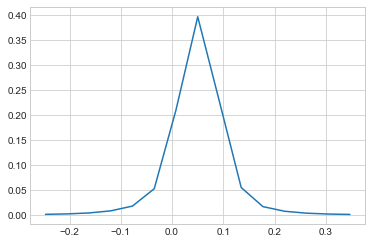

In [4]:
Nm = 15 # Number of points in grid 
nMoments = 4 # Number of moments to (try to) match 
rho = 0.5 # persistence of AR(1) process
if rho <= 1-2/(Nm-1):
    nSigmas = np.sqrt(2*(Nm-1));
else:
    nSigmas = np.sqrt(Nm-1);

mu = 0.05 # unconditonal mean 
sigmaC = np.array([0.1, 0.03]) # std. of normal dists.
muC = np.array([-0.004, 0.001]) # mean og normal dists. 
pC = np.array([0.16, 0.84]) # probability of drawing from each normal dist. (must sum to 1)
sigmaC2 = sigmaC**2 # variance

# first 4 uncentered moments of process 
# If no analytical expression exists these can be computed using numerical integration 
T1 = pC @ muC # mean
T2 = pC @ (muC**2+sigmaC2)  # uncentered second moment
T3 = pC @ (muC**3+3*muC*sigmaC2) # uncentered third moment
T4 = pC @ (muC**4+6*(muC**2)*sigmaC2+3*sigmaC2**2) # uncentered fourth moment

TBar = [T1, T2, T3, T4]

sigma = np.sqrt(T2-T1**2) # conditional standard deviation
temp = 1 / (1-np.kron(rho,rho)) 
sigmaX = sigma*np.sqrt(temp) # unconditional standard deviation    
X = np.linspace(mu-nSigmas*sigmaX,mu+nSigmas*sigmaX, Nm) # grid


condmean_f = lambda x : mu*(1-rho) + rho*x
q_func = lambda x : np.sum([p * ss.norm.pdf(x, mu, sd) for mu, sd, p in zip(muC, sigmaC, pC)], axis=0)  
scale = int((1 / (1-np.kron(rho,rho)) ))
tol=1e-05

# run discretization 
P, LambdaBar, momentError, q  = discr.discr_mixnorm(mu, Nm, nMoments, X, TBar, q_func, condmean_f, tol, scale)

pi = discr.stationary(P) # stationary distribution 
assert np.isclose(np.sum(pi), 1)
plt.plot(X, pi)
plt.show()

